In [142]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PredyNet_modules import *
import gym

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
env = gym.make("LunarLander-v2")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.00167799,  0.93480893, -0.16997133, -0.38696804,  0.00195111,
        0.03850099,  0.        ,  0.        ])

In [58]:
action_space = env.action_space.n
obs_space = env.observation_space.shape[0]

In [59]:
ySize = 8
predynet = PredyNet(inSize=obs_space, dSize=ySize)
yPrev = torch.randn(ySize)
ePrev = torch.zeros(obs_space)
optimizer = torch.optim.SGD(predynet.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(predynet.parameters(), lr=0.01)
criterion = F.smooth_l1_loss
# criterion = nn.SmoothL1Loss()

In [60]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [61]:
timelength = 10000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    optimizer.zero_grad()

    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

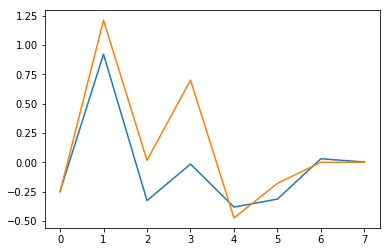

In [62]:
plt.plot(Rec.data.numpy())
plt.plot(obs_out[0])

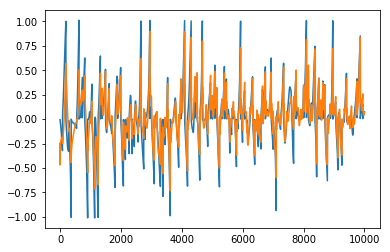

In [49]:
plt.plot(rX)
plt.plot(pX)
# plt.plot(rX-pX, 'r:')

In [63]:
timelength = 1000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)
Y = np.zeros((ySize, timelength))
env.reset()
act = env.action_space.sample()

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        
    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    err, ePrev, y, yPrev, Rec = predynet(observation[0], yPrev.detach(), ePrev)
    loss = criterion(Rec, observation)
    
    rX[t] = obs_out[0][0]
    pX[t] = Rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    Y[:,t] = y.data.numpy()
    
    if done:
        env.reset()

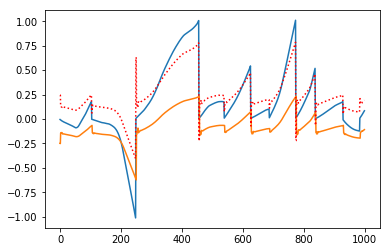

In [64]:
plt.plot(rX)
plt.plot(pX)
plt.plot(rX-pX, 'r:')

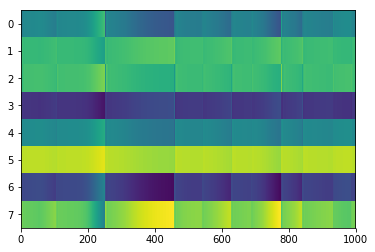

In [65]:
plt.imshow(Y, aspect="auto", interpolation="nearest")

In [66]:
yPrev.size()

torch.Size([8])

In [67]:
tmp = nn.LSTM(obs_space+action_space, 10)
act_tens = torch.eye(action_space)[act]
yPrev = torch.randn(1, 10).unsqueeze(0)
yPrev2 = torch.randn(1, 10).unsqueeze(0)
YP = (yPrev, yPrev2)
Inp = torch.cat((observation, act_tens), 0).unsqueeze(0).unsqueeze(0)

In [143]:
rec_model = PredyNet_LSTM(obs_space, action_space, 10)
yPrev = rec_model.init_hidden()

In [144]:
optimizer = torch.optim.SGD(rec_model.parameters(), lr=0.1)
criterion = F.smooth_l1_loss

In [145]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [146]:
timelength = 1000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]

for t in range(timelength):
    if np.random.rand() < 0.1:
        act = env.action_space.sample()
        act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act)
    observation = torch.Tensor(obs_out[0])
    done = obs_out[2]
    
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)

    Rec = rec_model(model_input)
    rec = Rec.squeeze()
    loss = criterion(rec, observation)
    loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    
    if done:
        env.reset()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

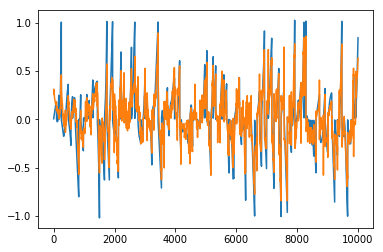

In [128]:
plt.plot(rX)
plt.plot(pX)
# plt.plot(rX-pX, 'r:')

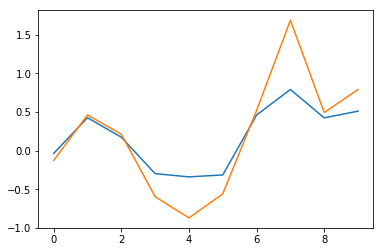

In [140]:
plt.plot(yPrev[0].squeeze().data.numpy())
plt.plot(yPrev[1].squeeze().data.numpy())